In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [3]:
def scorefunc(x, A,g):
    s1 = torch.matmul(x, A)
    score = -s1 + g*(x**2 - 1)*x
    return score

In [8]:
def gen_noisy_data(x0,step,temp,dt,device = "cpu"):
    x0 = x0.to(device)
    step = step.to(device)
    noise = torch.randn_like(x0).to(device)
    exp_t =torch.exp(-dt*(step+1)).view(-1, 1)
    std_t = torch.sqrt(temp*(1-exp_t*exp_t))
    noisy_data = x0*exp_t + noise*std_t
    return noisy_data, -noise/std_t

In [9]:
L = 8
N = L**2
temp = 3.17

MCS = 200000
P = 50000

T = 2

nSteps = 300
dt = 0.02

data = load_data(L,temp,MCS)
data = torch.from_numpy(data).to(torch.float32)

In [49]:
A = torch.randn((nSteps,N,N))/N**0.5
A = A.requires_grad_(True)
g = torch.randn((nSteps,1))/N**0.5
#tau = torch.randn((nSteps,1))/N**0.5
g = g.requires_grad_(True)
#tau = tau.requires_grad_(True)
n_epochs = 500
batch_size = 256
learning_rate = 0.1
optimizer = torch.optim.Adam([A,g],lr = learning_rate)
decay_rate = 1-np.log(10)/n_epochs
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
myloss = torch.nn.MSELoss()


In [50]:
500*512/P

5.12

In [51]:
for epochs in range(n_epochs):
    idx = np.random.choice(range(P),batch_size,replace =False)
    loss = 0
    for tt in range(nSteps):
        tnow = torch.Tensor([[tt+1,]])
        x_train,y_train = gen_noisy_data(data[idx],tnow,T,dt)
        loss += (myloss(scorefunc(x_train,A[tt],g[tt]),y_train) )/nSteps 
        #loss += (myloss(scorefunc(x_train,A[tt],B[tt]),y_train))/nSteps 
    loss+= 0.0005* torch.sum(torch.abs(A))/nSteps
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if (epochs+1)%100 ==0:
        print(f"epoch = {epochs+1}, loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}")


epoch = 100, loss = 0.0945889949798584, lr = 0.06302865857645837


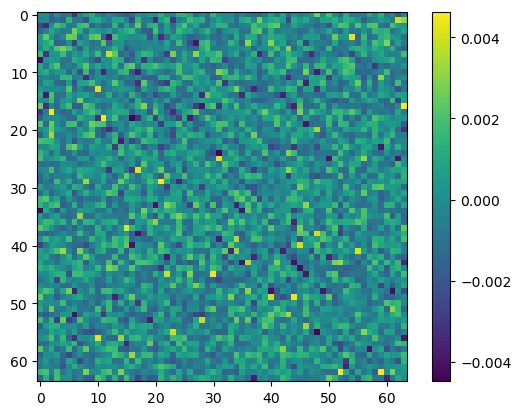

In [ ]:
plt.imshow((-A[0].detach().numpy() + np.diag(np.diag(A[0].detach().numpy()))))
plt.colorbar()

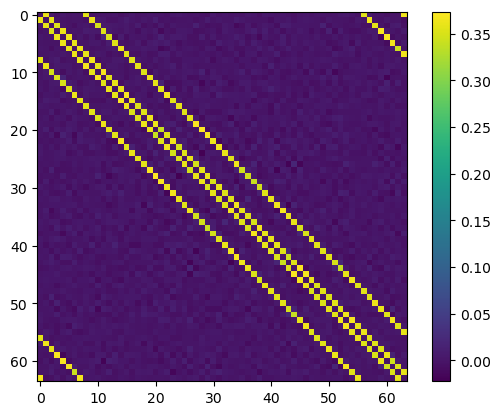

In [ ]:
Jtrue = np.linalg.inv(np.cov(data.T))
plt.imshow(-Jtrue+np.diag(np.diag(Jtrue)) )
plt.colorbar()

In [ ]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    with torch.no_grad():
        for tt in range(nSteps)[::-1]:
            std = np.sqrt(2*(temp)*dt)*torch.randn_like(xT)
            #den = np.sqrt(temp*(1-np.exp(-2*(tt+1))))
            
            for n in range(nbatches):
                if(full_traj):
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt],g[tt])
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size], A[tt],g[tt])
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
        
    return x_recon

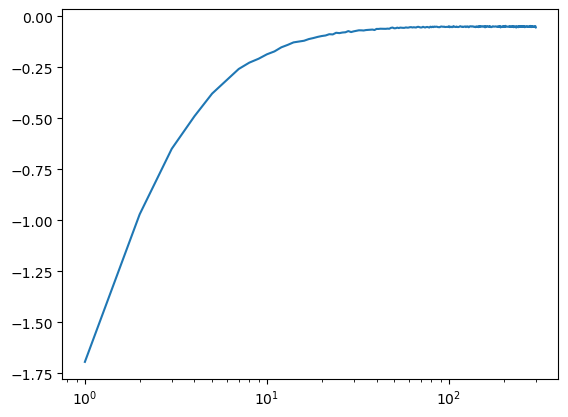

In [ ]:
A_optim = A.detach()
g_optim = g.detach().reshape(nSteps)
plt.plot([*range(1,1+nSteps)],g_optim.numpy())
#plt.axvline(np.log(N))
plt.xscale("log")

In [ ]:
xT = np.sqrt(T)*torch.randn((P,N))
x_recon = backward(xT,A_optim,g_optim,T,nSteps,dt).numpy()

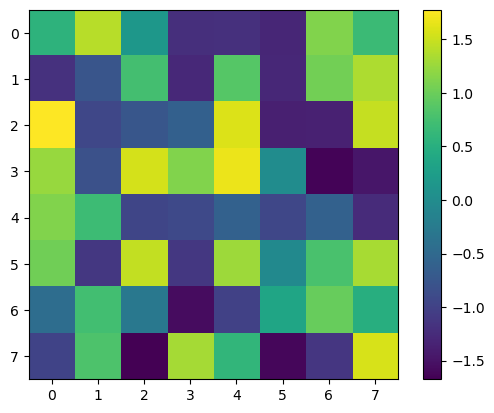

In [ ]:
plt.imshow(x_recon[0].reshape(L,L))
plt.colorbar()

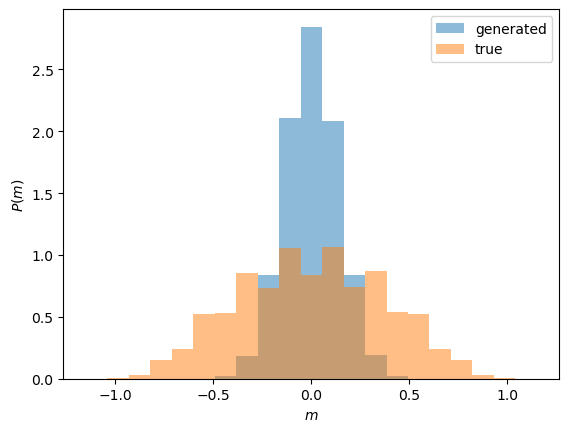

In [ ]:
plt.hist(np.mean(x_recon,axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "generated")
plt.hist(np.mean(data.numpy(),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()

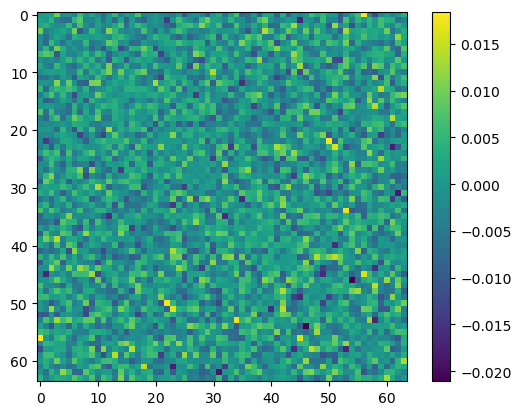

In [ ]:
Jpred = np.cov(x_recon.T)
Jpred = Jpred - np.diag(np.diag(Jpred))
plt.imshow(Jpred)
plt.colorbar()

(array([   9.,  119.,  769., 2521., 5133., 5846., 4654., 2705., 1744.,
        1375., 1261., 1610., 2339., 3717., 5410., 5730., 3493., 1274.,
         266.,   25.]),
 array([-2.38595915, -2.15193963, -1.91792011, -1.68390059, -1.44988108,
        -1.21586156, -0.98184204, -0.74782252, -0.51380301, -0.27978349,
        -0.04576397,  0.18825555,  0.42227507,  0.65629458,  0.8903141 ,
         1.12433362,  1.35835314,  1.59237266,  1.82639217,  2.06041169,
         2.29443121]),
 <BarContainer object of 20 artists>)

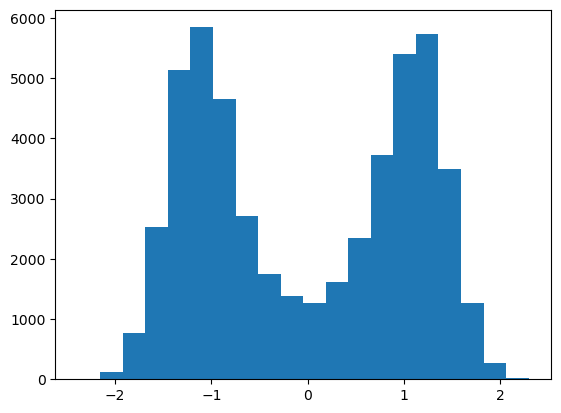

In [ ]:
plt.hist(x_recon[:,10],bins = 20)